In [ ]:
#extracting the images
import zipfile as zf
files = zf.ZipFile("images.zip", 'r')
files.extractall('/notebooks')
files.close()

In [1]:
!pip -q install matplotlib pandas sklearn

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
#dependencies
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras import backend as K

from sklearn.metrics import classification_report

import os
import warnings
import math

In [3]:
#parameters
batch_size = 64
train_dir = "images/training"
test_dir = "images/testing"
rand_seed=42

In [4]:
#loading InceptionV3 with pre-trained weights and without classifiers
pre_trained_model = InceptionV3(input_shape = (150,270,3), weights='imagenet', include_top=False)

2022-02-11 07:15:33.200140: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-11 07:15:33.220543: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-11 07:15:33.221433: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-11 07:15:33.224646: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-11 07:15:33.225555: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

87924736/87910968 [==============================] - 4s 0us/step


In [5]:
#set layers to be non-trainable for pre-trained model (freeze)
for layer in pre_trained_model.layers:
    layer.trainable = False

In [6]:
#image augmentation applied to training images
train_gen = ImageDataGenerator(rescale = 1./255,
                               rotation_range=40,
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.2,
                               shear_range=0.2,
                               horizontal_flip=True,
                               fill_mode='nearest').flow_from_directory(train_dir, 
                                                                        class_mode='binary',
                                                                        target_size=(270, 150), 
                                                                        batch_size=batch_size,
                                                                        seed=rand_seed, 
                                                                        shuffle=True)

#no image augmentation applied to test images
test_gen = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_dir, 
                                                                    class_mode='binary',
                                                                    target_size=(270, 150), 
                                                                    batch_size=batch_size,
                                                                    seed=rand_seed, 
                                                                    shuffle=True)

Found 2392 images belonging to 2 classes.
Found 597 images belonging to 2 classes.


Showing 10 images from the first batch


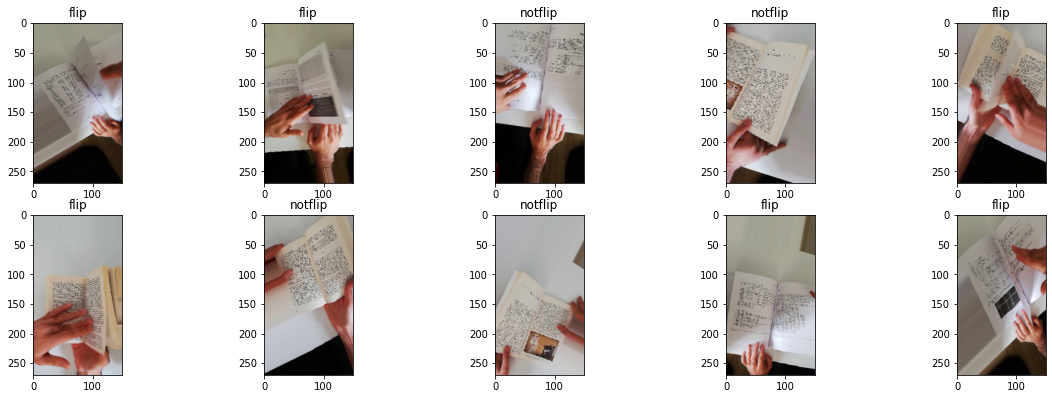

In [7]:
#viewing the training data
new_dict = {}
for key, value in train_gen.class_indices.items():
  new_dict[value] = key

def label_plot(x):
      return new_dict[x]

batch = next(train_gen)  # returns the next batch of images and labels as tupe where 0 index is images and 1 is label

plt.figure(figsize=(20,10))
columns = 5

new_dict = {}
for key, value in train_gen.class_indices.items():
  new_dict[value] = key

#plotting the first 10 images from one of the batch
print("Showing 10 images from the first batch")
for idx in range(10):
  plt.subplot(int(len(range(10))/columns + 1), columns, idx + 1)
  plt.title(label_plot(batch[1][idx]))
  plt.imshow(batch[0][idx])

In [8]:
#using the pre_trained_model as feature extractor in our model
#flatten the output layer from pre trained model to 1 dimension
model = layers.Flatten()(pre_trained_model.output)
#add a fully connected layer
model = layers.Dense(1024, activation='relu')(model)
#add a final sigmoid layer for classification
model = layers.Dense(1, activation='sigmoid')(model)
model = tf.keras.Model(pre_trained_model.input, model)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics = ['accuracy'])

In [9]:
#learning rate finder
#modified version of https://github.com/surmenok/keras_lr_finder that is compatible for Tensorflow >2.0

import os
import numpy as np
import warnings

from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K

import numpy as np
import scipy.ndimage.filters as filters
import scipy.ndimage.morphology as morphology
import pandas as pd


def detect_local_minima(arr):
    # https://stackoverflow.com/questions/4624970/finding-local-maxima-minima-with-numpy-in-a-1d-numpy-array
    # https://stackoverflow.com/questions/3986345/how-to-find-the-local-minima-of-a-smooth-multidimensional-array-in-numpy-efficien
    # https://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array/3689710#3689710
    """
    Takes an array and detects the troughs using the local maximum filter.
    Returns a boolean mask of the troughs (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """
    # define an connected neighborhood
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#generate_binary_structure
    neighborhood = morphology.generate_binary_structure(len(arr.shape), 2)
    # apply the local minimum filter; all locations of minimum value
    # in their neighborhood are set to 1
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.filters.html#minimum_filter
    local_min = (filters.minimum_filter(arr, footprint=neighborhood) == arr)
    # local_min is a mask that contains the peaks we are
    # looking for, but also the background.
    # In order to isolate the peaks we must remove the background from the mask.
    #
    # we create the mask of the background
    background = (arr == 0)
    #
    # a little technicality: we must erode the background in order to
    # successfully subtract it from local_min, otherwise a line will
    # appear along the background border (artifact of the local minimum filter)
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#binary_erosion
    eroded_background = morphology.binary_erosion(
        background, structure=neighborhood, border_value=1)
    #
    # we obtain the final mask, containing only peaks,
    # by removing the background from the local_min mask
    detected_minima = local_min ^ eroded_background
    return np.where(detected_minima)


def moving_average_fast(x, w):
    # https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
    return np.convolve(np.array(x), np.ones(w), 'same') / w


def moving_average(x, w):
    df = pd.DataFrame({"x": x})
    return df.rolling(w, win_type=None, min_periods=1, center=True).mean()['x'].values

def get_derivatives(vals, sma=10):
    assert sma >= 1
    derivatives = [0] * sma
    losses = moving_average(vals, 5)
    for i in range(sma, len(vals)):
        derivatives.append((losses[i] - losses[i - sma]) / sma)
    return derivatives


from matplotlib import pyplot as plt
import math
from tensorflow.keras.callbacks import LambdaCallback
import tensorflow.keras.backend as K
import numpy as np


class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """

    def __init__(self, model, num_validation_batches=10):
        self.model = model
        self.losses = []
        self.acc = []
        self.lrs = []
        self.best_loss = 1e9
        self.best_acc = 0
        self.one_minus_acc = []
        self.one_minus_acc_best = []
        self.num_validation_batches = num_validation_batches
        self.validation_set = None
        self.validation_generator = None

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        acc = logs['accuracy']

        self.losses.append(loss)
        self.acc.append(acc)
        self.one_minus_acc.append(1 - acc)

        # Check whether the loss got too large or NaN
        if batch > 16 and (math.isnan(loss) or loss > self.best_loss * 10):
            self.model.stop_training = True
            print("Stop Training at %s, loss = %.3f" % (batch, loss))
            return

        if loss < self.best_loss:
            self.best_loss = loss
        if acc > self.best_acc:
            self.best_acc = acc

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr,
             x_test=None, y_test=None,
             batch_size=64, epochs=1):
        num_batches = epochs * x_train.shape[0] / batch_size
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(num_batches))

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))
        self.validation_set = (x_test, y_test) if x_test is not None and y_test is not None else None
        self.batch_size = batch_size

        self.model.fit(x_train, y_train,
                       batch_size=batch_size, epochs=epochs,
                       verbose=0,
                       callbacks=[callback])

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def find_generator(self, generator, start_lr, end_lr,
                       test_generator=None,
                       epochs=1, steps_per_epoch=None, **kw_fit):
        if steps_per_epoch is None:
            try:
                steps_per_epoch = len(generator)
            except (ValueError, NotImplementedError) as e:
                raise e('`steps_per_epoch=None` is only valid for a'
                        ' generator based on the '
                        '`keras.utils.Sequence`'
                        ' class. Please specify `steps_per_epoch` '
                        'or use the `keras.utils.Sequence` class.')
        self.lr_mult = (float(end_lr) / float(start_lr)) ** (float(1) / float(steps_per_epoch * epochs))

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch,
                                                      logs: self.on_batch_end(batch, logs))

        self.validation_generator = test_generator

        self.model.fit_generator(generator=generator,
                                 epochs=epochs,
                                 steps_per_epoch=steps_per_epoch,
                                 callbacks=[callback],
                                 verbose=0,
                                 **kw_fit)

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=5, n_skip_end=5, sma=20):
        self.__plot__(n_skip_beginning,n_skip_end,sma,use_acc=False)

    def plot_one_minus_acc(self, n_skip_beginning=5, n_skip_end=5, sma=20):
        self.__plot__(n_skip_beginning,n_skip_end,sma,use_acc=True)

    def __plot__(self, n_skip_beginning=5, n_skip_end=5, sma=10, use_acc=False):

        fig = plt.figure(figsize=(12, 6))
        ax = fig.add_subplot(111)
        y_label = "1 - Acc" if use_acc else "loss"
        plt.ylabel(y_label)
        plt.xlabel("learning rate (log scale)")

        losses = self.losses if not use_acc else self.one_minus_acc
        losses = moving_average(losses, sma)

        losses = losses[n_skip_beginning:-n_skip_end]

        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], losses)
        plt.xscale('log')
        best_lrs = self.get_best_lrs(sma,use_acc=use_acc)
        lrs = [x for x, _ in best_lrs]
        positions = [x for _, x in best_lrs]
        # https://matplotlib.org/users/annotations_intro.html
        # for lr, pos in [best_lrs[-1]]:
        #     ax.annotate('LR = %.3f, %s = %.2f' % (lr, y_label, losses[pos]), xy=(lr, losses[pos]),
        #                 xytext=(lr + 0.2, losses[pos] + 0.1),
        #                 arrowprops=dict(facecolor='black', shrink=0.03, width=1, frac=0.05),
        #                 )

        title = "LR vs 1 - Acc Graph" if use_acc else "LR vs Loss Graph"
        # title = title + "\n" + "Best Candidate LR = %s" % lrs
        plt.title(title)
        plt.show()

    def __get_best_lr_method1__(self, sma=20, n_skip_beginning=10, n_skip_end=5, use_acc=False):
        losses = self.losses if not use_acc else self.one_minus_acc
        derivatives = get_derivatives(losses, sma)
        losses = np.array(losses[n_skip_beginning:-n_skip_end])
        derivatives = derivatives[n_skip_beginning:-n_skip_end]
        lrs = self.lrs[n_skip_beginning:-n_skip_end]

        best_loss = (1 - self.best_acc) if use_acc else self.best_loss
        acceptable_idxs = np.where(losses <= best_loss * 1.75)[0]

        derivatives = derivatives[acceptable_idxs[0]:acceptable_idxs[-1]]

        best_idxs = np.argpartition(derivatives, -5)[-5:]
        best_idxs = best_idxs - sma + acceptable_idxs[0]
        acceptable_loss_or_not = losses[best_idxs] <= best_loss * 1.5
        best_idxs = best_idxs[acceptable_loss_or_not]

        acceptable_loss_or_not = losses[best_idxs + sma] > (losses[best_idxs] * 1.0)
        best_idxs = best_idxs[acceptable_loss_or_not]

        candidates = list(np.array(lrs)[best_idxs])
        return sorted(candidates), best_idxs

    def get_best_lrs(self, sma=20, n_skip_beginning=10, n_skip_end=5, use_acc=False):
        c1, i1 = self.__get_best_lr_method1__(sma, n_skip_beginning, n_skip_end, use_acc)
        candidates = list(zip(c1, i1))
        candidates = sorted(candidates, key=lambda pair: pair[0])
        final_candidates = [candidates[0]]
        for v, i in candidates:
            if (v - final_candidates[-1][0]) / final_candidates[-1][0] > 0.2:
                final_candidates.append((v, i))
        final_candidates = list(map(lambda pair: (float("%.3f" % pair[0]), pair[1]), final_candidates))
        return final_candidates


/usr/local/lib/python3.8/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


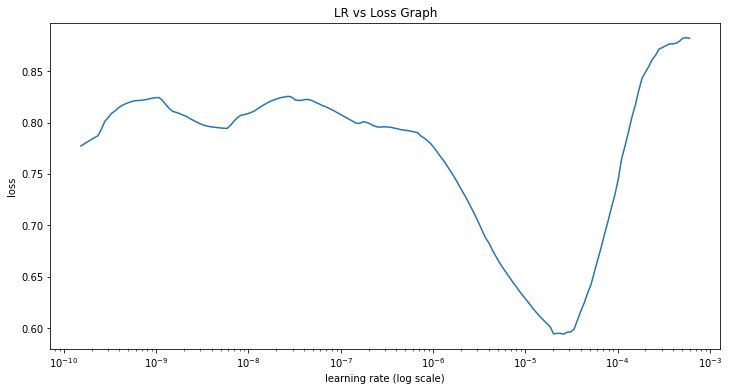

In [11]:
#instantiating the learning rate finder
lr_finder = LRFinder(model)
# Train a model with learning rate growing exponentially from 1e-10 to 1e-3
lr_finder.find_generator(train_gen, start_lr=1e-10, end_lr=1e-3, epochs=5)
# Plot the loss
lr_finder.plot_loss()

In [12]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 270, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 134, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 134, 32)  96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 134, 32)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
#training the model using a learning rate of 1e-5, which seems optimal from the curve above
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-5), loss="binary_crossentropy", metrics = ['accuracy'])
history = model.fit(train_gen, validation_data = test_gen, steps_per_epoch = len(train_gen), validation_steps = len(test_gen), epochs=20, verbose=1)

Epoch 1/20
38/38 [==============================] - 73s 2s/step - loss: 0.6237 - accuracy: 0.6948 - val_loss: 0.4111 - val_accuracy: 0.8074
Epoch 2/20
38/38 [==============================] - 56s 1s/step - loss: 0.4327 - accuracy: 0.7885 - val_loss: 0.4050 - val_accuracy: 0.8107
Epoch 3/20
38/38 [==============================] - 56s 1s/step - loss: 0.4129 - accuracy: 0.8094 - val_loss: 0.2898 - val_accuracy: 0.8660
Epoch 4/20
38/38 [==============================] - 59s 2s/step - loss: 0.3625 - accuracy: 0.8386 - val_loss: 0.3458 - val_accuracy: 0.8409
Epoch 5/20
38/38 [==============================] - 58s 2s/step - loss: 0.3485 - accuracy: 0.8416 - val_loss: 0.4096 - val_accuracy: 0.8174
Epoch 6/20
38/38 [==============================] - 58s 2s/step - loss: 0.3303 - accuracy: 0.8583 - val_loss: 0.2715 - val_accuracy: 0.8961
Epoch 7/20
38/38 [==============================] - 58s 2s/step - loss: 0.3062 - accuracy: 0.8717 - val_loss: 0.2533 - val_accuracy: 0.8878
Epoch 8/20
38/38 [==

In [14]:
#evaluating the model

#turning off the shuffle in test data
test_gen = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_dir, 
                                                                    class_mode='binary',
                                                                    target_size=(270, 150), 
                                                                    batch_size=batch_size,
                                                                    seed=rand_seed, 
                                                                    shuffle=False)

#prediction
preds = model.predict(test_gen, steps = len(test_gen))

#converting prediciton to 0 and 1 using threshold of 0.5
for idx, pred in enumerate(preds):
  if pred < 0.5:
    preds[idx] = 0
  else:
    preds[idx] = 1

target_names = list(test_gen.class_indices.keys())   
print(classification_report(test_gen.classes, preds, target_names=target_names))

Found 597 images belonging to 2 classes.
              precision    recall  f1-score   support

        flip       0.98      0.85      0.91       290
     notflip       0.87      0.98      0.92       307

    accuracy                           0.92       597
   macro avg       0.93      0.92      0.92       597
weighted avg       0.92      0.92      0.92       597



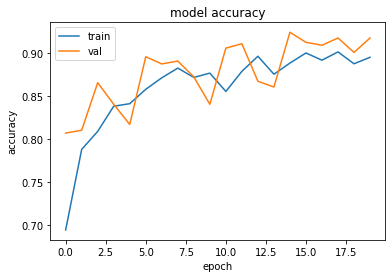

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

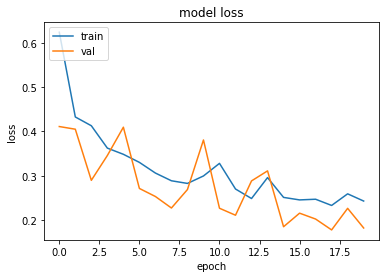

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Fine-tuning

In [17]:
#set layers to be non-trainable for pre-trained model (un-freeze)
for layer in pre_trained_model.layers:
    layer.trainable = True

In [18]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(pre_trained_model.layers))

Number of layers in the base model:  311


In [19]:
# Fine-tune from this layer onwards
fine_tune_at = 280

In [20]:
# Freeze all the layers before the `fine_tune_at` layer
for layer in pre_trained_model.layers[:fine_tune_at]:
  layer.trainable = False

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 270, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 134, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 134, 32)  96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 134, 32)  0           batch_normalization[0][0]        
______________________________________________________________________________________________

/usr/local/lib/python3.8/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


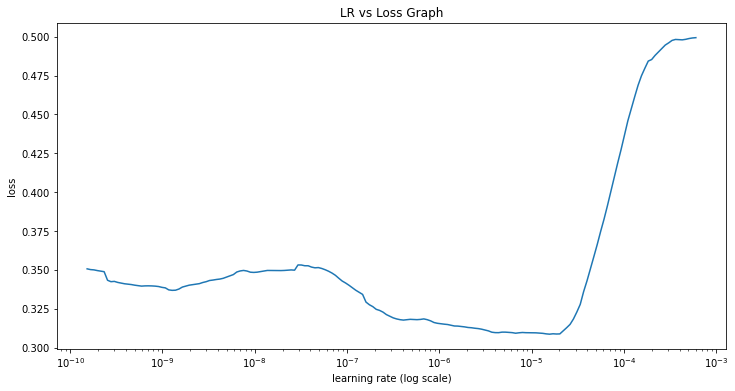

In [23]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics = ['accuracy'])
lr_finder = LRFinder(model)
# Train a model with learning rate growing exponentially from 1e-10 to 1e-3
lr_finder.find_generator(train_gen, start_lr=1e-10, end_lr=1e-3, epochs=5)
# Plot the loss
lr_finder.plot_loss()

In [24]:
fine_tune_epochs = 10
total_epochs =  20 + fine_tune_epochs

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 1e-6), loss="binary_crossentropy", metrics = ['accuracy'])
history_fine = model.fit(train_gen, validation_data = test_gen, steps_per_epoch = len(train_gen), initial_epoch=history.epoch[-1], validation_steps = len(test_gen), epochs=total_epochs, verbose=1)

Epoch 20/30
38/38 [==============================] - 66s 2s/step - loss: 0.3064 - accuracy: 0.8746 - val_loss: 0.2462 - val_accuracy: 0.8894
Epoch 21/30
38/38 [==============================] - 61s 2s/step - loss: 0.2945 - accuracy: 0.8888 - val_loss: 0.2336 - val_accuracy: 0.8995
Epoch 22/30
38/38 [==============================] - 61s 2s/step - loss: 0.2911 - accuracy: 0.8905 - val_loss: 0.2182 - val_accuracy: 0.9112
Epoch 23/30
38/38 [==============================] - 62s 2s/step - loss: 0.2830 - accuracy: 0.8905 - val_loss: 0.2247 - val_accuracy: 0.9129
Epoch 24/30
38/38 [==============================] - 61s 2s/step - loss: 0.2771 - accuracy: 0.8938 - val_loss: 0.2406 - val_accuracy: 0.8928
Epoch 25/30
38/38 [==============================] - 62s 2s/step - loss: 0.2803 - accuracy: 0.8946 - val_loss: 0.2328 - val_accuracy: 0.8995
Epoch 26/30
38/38 [==============================] - 61s 2s/step - loss: 0.2596 - accuracy: 0.9001 - val_loss: 0.2426 - val_accuracy: 0.8928
Epoch 27/30
3

In [26]:
#evaluating the model

#turning off the shuffle in test data
test_gen = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_dir, 
                                                                    class_mode='binary',
                                                                    target_size=(270, 150), 
                                                                    batch_size=batch_size,
                                                                    seed=rand_seed, 
                                                                    shuffle=False)

#prediction
preds = model.predict(test_gen, steps = len(test_gen))

#converting prediciton to 0 and 1 using threshold of 0.5
for idx, pred in enumerate(preds):
  if pred < 0.5:
    preds[idx] = 0
  else:
    preds[idx] = 1

target_names = list(test_gen.class_indices.keys())   
print(classification_report(test_gen.classes, preds, target_names=target_names))

Found 597 images belonging to 2 classes.
              precision    recall  f1-score   support

        flip       0.95      0.87      0.90       290
     notflip       0.88      0.95      0.92       307

    accuracy                           0.91       597
   macro avg       0.91      0.91      0.91       597
weighted avg       0.91      0.91      0.91       597



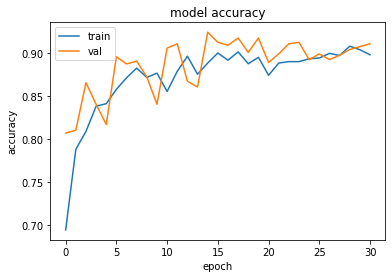

In [27]:
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'])
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

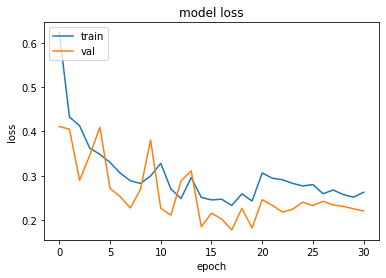

In [28]:
plt.plot(history.history['loss'] + history_fine.history['loss'])
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Fine tuning hasn't improved the model. I am going to stop the training here in the interest of not overfitting the network to the data